In [1]:
import jax
import jax.numpy as jnp
from functools import partial
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Calculates local energy of a given positions and laplacian

class ManyBodyHamiltonian:

    def __init__(self, potential_energy_fn=None, mass=1.0, omega=1.0, hbar=1.0):
        self.mass = mass
        self.omega = omega
        self.hbar = hbar
        self.potential_energy_fn = potential_energy_fn

    @partial(jax.jit, static_argnums=(0,))
    def kinetic_energy(self, psi, psi_laplacian):
        """Local Kinetic energy: T = (- (ħ² / 2m)) ∇²Ψ/Ψ, approximated by gradients.
        - psi: value of the wavefunction in position
        - psi_laplacian: the laplacian of the wavefunction in the position required
        """
        return -(((self.hbar)**2)/(2 * self.mass)) * psi_laplacian / psi


    @partial(jax.jit, static_argnums=(0,))
    def potential_energy(self, position):
        """Local Potential energy for harmonic oscillator: V = 0.5 * m * ω² * r².
        - position: must be the position sampled by the wavefunction probability
        """
        return 0.5 * self.mass * (self.omega ** 2) * position**2

    @partial(jax.jit, static_argnums=(0,))
    def total_energy(self, position, psi, psi_laplacian):
        """Total energy: E = T + V."""
        kinetic = self.kinetic_energy(psi, psi_laplacian)
        potential = self.potential_energy(position)
        return kinetic + potential

    @partial(jax.jit, static_argnums=(0,))
    def variational_energy(self, psi, positions, psi_laplacians):
        return jnp.mean(self.total_energy_vmap(psi, positions, psi_laplacians))

    #######################
    # vmapped functions
    #######################

    @partial(jax.vmap, in_axes = (None, 0, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def kinetic_energy_vmap(self, psi, psi_laplacian):
        """Local Kinetic energy: T = (- (ħ² / 2m)) ∇²Ψ/Ψ, approximated by gradients.
        - psi_laplacian: the laplacian of the wavefunction in all the positions sampled
        """
        return -0.5 * (((self.hbar)**2)/(2 * self.mass)) * psi_laplacian / psi

    @partial(jax.vmap, in_axes = (None, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def potential_energy_vmap(self, positions):
        """Potential energy for harmonic oscillator: V = 0.5 * m * ω² * r².
        - positions: must be the positions sampled by the wavefunction probability
        """
        return 0.5 * self.omega * self.mass * (self.omega ** 2) * positions**2

    @partial(jax.vmap, in_axes = (None, 0, 0, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def total_energy_vmap(self, psi, positions, psi_laplacian):
        """Total energy: E = T + V."""
        kinetic = self.kinetic_energy(psi, psi_laplacian)
        potential = self.potential_energy(positions)
        return kinetic + potential

In [ ]:
class TrialWavefunction:
    def __init__(self, params=None):
        if params == None:
            params = jnp.array(np.random.normal())
        self.params = params

    @partial(jax.jit, static_argnums=(0,))
    def evaluate_wf(self, position):
        """Evaluate the Gaussian wavefunction: Ψ(x) = exp(-α * r²)."""
        alpha = self.params[0]
        return jnp.exp(-alpha * position**2)

    @partial(jax.jit, static_argnums=(0,))
    def evaluate_log_wf(self, params, position):
        """Evaluate the Gaussian wavefunction: Ψ(x) = exp(-α * r²)."""
        alpha = params[0]
        return jnp.log(jnp.exp(-alpha * position**2))

    @partial(jax.jit, static_argnums=(0,))
    def probability_function(self, position):
        return self.evaluate_wf(position)**2

    @partial(jax.jit, static_argnums=(0,))
    def grad_wf(self, position):
        return jax.grad(self.evaluate_wf, argnums=0)(position)

    @partial(jax.jit, static_argnums=(0,))
    def laplacian_wf(self, position):
        return jax.grad(self.grad_wf, argnums = 0)(position)

    @partial(jax.jit, static_argnums=(0,))
    def var_log_grads(self, params, position):
        return jax.grad(self.evaluate_log_wf, argnums=0)(params, position)

    #######################
    # vmapped functions
    #######################

    @partial(jax.vmap, in_axes = (None, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def evaluate_wf_vmap(self, positions):
        """Evaluate the Gaussian wavefunction: Ψ(x) = exp(-α * r²)."""
        alpha = self.params[0]
        return jnp.exp(-alpha * positions**2)

    @partial(jax.vmap, in_axes = (None, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def grad_wf_vmap(self, positions):
        return jax.grad(self.evaluate_wf, argnums=0)(positions)

    @partial(jax.vmap, in_axes = (None, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def laplacian_wf_vmap(self, positions):
        return jax.grad(self.grad_wf, argnums = 0)(positions)

    @partial(jax.vmap, in_axes = (None, None, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def var_log_grads_vmap(self, params, position):
        return jax.grad(self.evaluate_log_wf, argnums=0)(params, position)

    @partial(jax.vmap, in_axes = (None, 0), out_axes = 0)
    @partial(jax.jit, static_argnums=(0,))
    def probability_function_vmap(self, position):
        return self.evaluate_wf(position)**2

In [ ]:
class MetropolisHastingsSampler:
    def __init__(self, trial_wavefunction, rng_key = None, step_size=0.01):
        if rng_key==None:
            rng_key = jax.random.PRNGKey(np.random.randint(10_000))
        self.step_size = step_size
        self.key = rng_key
        self.trial_wavefunction = trial_wavefunction

    @partial(jax.jit, static_argnums=(0,))
    def propose_move(self, positions, key):
        """Propose a new move by adding Gaussian noise to the current positions."""
        key, new_key = jax.random.split(key)
        move = jax.random.normal(new_key, shape=positions.shape) * self.step_size
        new_positions = positions + move
        return new_positions, key

    @partial(jax.jit, static_argnums=(0,))
    def acceptance_prob(self, old_positions, new_positions):
        """Compute the Metropolis-Hastings acceptance probability."""
        prob_old = self.trial_wavefunction.probability_function(position = old_positions)
        prob_new = self.trial_wavefunction.probability_function(position = new_positions)
        return jnp.minimum(1.0, prob_new / prob_old)

    @partial(jax.jit, static_argnums=(0,))
    def metropolis_step(self, positions, key):
        """Perform a single Metropolis-Hastings step."""
        key, sub_key = jax.random.split(key)
        new_positions, key = self.propose_move(positions, key)
        acc_prob = self.acceptance_prob(positions, new_positions)
        accept = jax.random.uniform(sub_key) < acc_prob
        positions = jnp.where(accept, new_positions, positions)
        return positions, key

    def sample(self, initial_positions, num_samples, burn_in=1_000):
        """Generate samples using Metropolis-Hastings with fori_loop."""

        # Define a burn-in loop function
        def sample_step(i, carry):
            positions, key = carry
            positions, key = self.metropolis_step(positions, key)
            return positions, key

        # Define a burn-in loop function
        def sample_scan(carry, x):
            positions, key = carry
            positions, key = self.metropolis_step(positions, key)
            return (positions, key), positions

        # Burn-in phase
        positions, key = jax.lax.fori_loop(0, burn_in, sample_step, (initial_positions, self.key))

        # Sampling phase
        (positions, key), samples = jax.lax.scan(sample_scan, (positions, key), None, num_samples)

        self.key = key

        return samples

In [ ]:
class GradientDescentOptimizer:
    def __init__(self, learning_rate=0.1):
        self.lr = learning_rate

    def optimizer(self, params, grads):
        return [p - self.lr*jnp.mean(grad, axis=0) for p, grad in zip(params, grads)]
#        return [p - self.lr*jnp.mean(grad, axis = 0) for p, grad in zip(params, grads)]

In [13]:
class optimization_driver:
    def __init__(self, hamiltonian, trial_wavefunction, sampler, optimizer, num_samples = 10_000, burn_in = 1_000):
        self.hamiltonian = hamiltonian
        self.trial_wavefunction = trial_wavefunction
        self.sampler = sampler
        self.optimizer = optimizer
        self.num_samples = num_samples
        self.burn_in = burn_in
        self.coso = None

    def energy_gradient(self, samples):
        psi = self.trial_wavefunction.evaluate_wf_vmap(samples)
        psi_laplacian = self.trial_wavefunction.laplacian_wf_vmap(samples)
        grad_log_psi = self.trial_wavefunction.var_log_grads_vmap(self.trial_wavefunction.params, samples)
        local_energies = self.hamiltonian.total_energy_vmap(psi, samples, psi_laplacian)
        variational_energy = jnp.mean(local_energies)
        return jnp.mean(jnp.array([2*jnp.real((loc_en - variational_energy)*grad) for loc_en, grad in zip(local_energies, grad_log_psi)]), axis=0)

    @partial(jax.jit, static_argnums = (0,))
    @partial(jax.vmap, in_axes = (None, 0, 0, None), out_axes = 0)
    def energy_gradient_vmap(self, grad_log_psi, loc_energy, var_energy):
        return [2*jnp.real((loc_energy - var_energy)*grad) for grad in grad_log_psi]

    def run(self, n_iters):
        key = self.sampler.key

        for i in range(n_iters):
            key, subkey = jax.random.split(key)
            self.sampler.key = key
            initial_positions = -0.5 + jax.random.uniform(subkey)
            samples = self.sampler.sample(initial_positions, self.num_samples, self.burn_in)
            psi = self.trial_wavefunction.evaluate_wf_vmap(samples)
            psi_laplacian = self.trial_wavefunction.laplacian_wf_vmap(samples)
            grad_log_psi = self.trial_wavefunction.var_log_grads_vmap(self.trial_wavefunction.params, samples)
            local_energies = self.hamiltonian.total_energy_vmap(psi, samples, psi_laplacian)
            variational_energy = jnp.mean(local_energies)
            energy_gradient = self.energy_gradient_vmap(grad_log_psi, local_energies, variational_energy)
            self.trial_wavefunction.params = self.optimizer.optimizer(self.trial_wavefunction.params, energy_gradient)
            if i%10==0:
                print("Step ", i)
                print("params = ", self.trial_wavefunction.params)
                print("Variational energy: ", variational_energy)
                #print("Energy gradients: ", energy_gradient)
                self.coso = energy_gradient

In [11]:
from scipy.stats import sem
from matplotlib import pyplot as plt

energies = []
delta_energies = []
alpha_values = np.linspace(0.4, 0.6, 100)
opt = GradientDescentOptimizer(0.005)
hamiltonian = ManyBodyHamiltonian()
for alpha in alpha_values:
    trial = TrialWavefunction([jnp.array(alpha)])
    sampler = MetropolisHastingsSampler(trial, step_size=0.1)
    initial_positions = -0.5 + np.random.uniform()
    samples = sampler.sample(initial_positions, num_samples=1_000_000, burn_in=25_000)
    psi = trial.evaluate_wf_vmap(samples)
    laplacians = trial.laplacian_wf_vmap(samples)
    variational_energy = hamiltonian.total_energy_vmap(psi, samples, laplacians)
    energy, delta_energy = np.average(variational_energy), sem(variational_energy)
    energies.append(energy)
    delta_energies.append(delta_energy)
    print('%5.3f \t %7.5f ± %f' % (alpha,energy,delta_energy))

0.400 	 0.50642 ± 0.000149
0.402 	 0.51474 ± 0.000161
0.404 	 0.51116 ± 0.000150
0.406 	 0.50976 ± 0.000145
0.408 	 0.50924 ± 0.000142
0.410 	 0.50870 ± 0.000141
0.412 	 0.50910 ± 0.000135
0.414 	 0.50804 ± 0.000132
0.416 	 0.50717 ± 0.000129
0.418 	 0.50745 ± 0.000125
0.420 	 0.50657 ± 0.000124
0.422 	 0.50707 ± 0.000119
0.424 	 0.50892 ± 0.000120
0.426 	 0.50764 ± 0.000114
0.428 	 0.50680 ± 0.000113
0.430 	 0.50668 ± 0.000107
0.432 	 0.50540 ± 0.000102
0.434 	 0.50428 ± 0.000099
0.436 	 0.50637 ± 0.000098
0.438 	 0.50441 ± 0.000093
0.440 	 0.50254 ± 0.000089
0.442 	 0.50476 ± 0.000089
0.444 	 0.50304 ± 0.000083
0.446 	 0.50241 ± 0.000080
0.448 	 0.50195 ± 0.000076
0.451 	 0.50297 ± 0.000075
0.453 	 0.50136 ± 0.000070
0.455 	 0.50266 ± 0.000068
0.457 	 0.50142 ± 0.000062
0.459 	 0.50242 ± 0.000062
0.461 	 0.50203 ± 0.000059
0.463 	 0.50160 ± 0.000055
0.465 	 0.50207 ± 0.000053
0.467 	 0.50074 ± 0.000049
0.469 	 0.50116 ± 0.000045
0.471 	 0.50092 ± 0.000042
0.473 	 0.50062 ± 0.000039
0

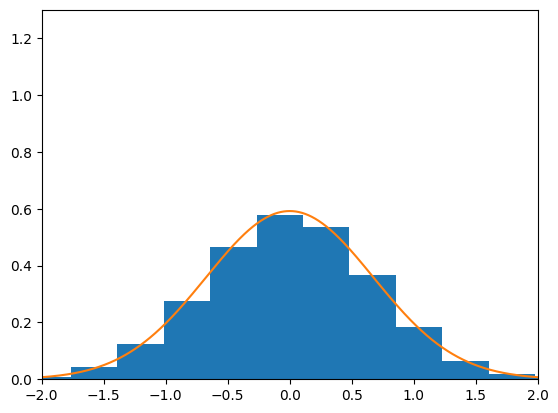

In [197]:
import scipy.integrate as integrate

x = np.linspace(-10, 10, 10_000)
integral = integrate.quad(lambda x: trial.probability_function(x), -10., 10.)[0]
y = trial.probability_function_vmap(x)/integral
plt.hist(samples, density=True, bins=15)
plt.plot(x, y)
plt.xlim([-2., 2.])
plt.ylim([0.0, 1.3])
plt.savefig("MonteCarlo.svg", dpi=300)

In [149]:
trial.probability_function(-3)

Array(5.0174654e-05, dtype=float32)

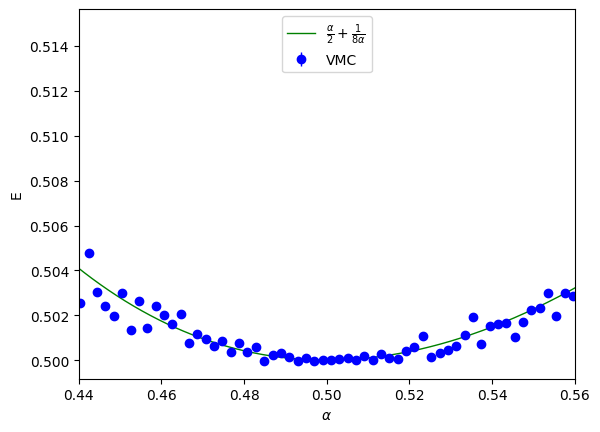

In [12]:
alpha = np.linspace(alpha_values[0],alpha_values[-1],1000)
plt.plot(alpha,0.5*alpha + 1/(8*alpha), '-', linewidth=1, color='green', zorder=-10,
         label=r'$\frac{\alpha}{2} + \frac{1}{8\alpha}$')
plt.errorbar(alpha_values,energies,yerr=delta_energies, linestyle='None', marker='o', elinewidth=1.0,
             markersize=6, markerfacecolor='blue', markeredgecolor='blue', ecolor='blue', label='VMC')
plt.xlabel(r'$\alpha$')
plt.ylabel('E');
plt.xlim(0.44,0.56)
plt.legend(loc='upper center')

In [14]:
trial = TrialWavefunction([jnp.array(0.4)])
sampler = MetropolisHastingsSampler(trial, step_size=0.1)
opt = GradientDescentOptimizer(0.005)
initial_positions = 0.0
samples = sampler.sample(initial_positions, num_samples=1_000_000, burn_in=25_000)
psi = trial.evaluate_wf_vmap(samples)
laplacians = trial.laplacian_wf_vmap(samples)
hamiltonian = ManyBodyHamiltonian()
driver = optimization_driver(hamiltonian, trial, sampler, opt)
driver.run(500)

Step  0
params =  [Array(0.40125102, dtype=float32)]
Variational energy:  0.5149789
Step  10
params =  [Array(0.42035124, dtype=float32)]
Variational energy:  0.5098489
Step  20
params =  [Array(0.4397691, dtype=float32)]
Variational energy:  0.5127542
Step  30
params =  [Array(0.45900342, dtype=float32)]
Variational energy:  0.51108575
Step  40
params =  [Array(0.47865847, dtype=float32)]
Variational energy:  0.51328254
Step  50
params =  [Array(0.49786505, dtype=float32)]
Variational energy:  0.5088847
Step  60
params =  [Array(0.51711315, dtype=float32)]
Variational energy:  0.5094706
Step  70
params =  [Array(0.53651863, dtype=float32)]
Variational energy:  0.51228577
Step  80
params =  [Array(0.5560358, dtype=float32)]
Variational energy:  0.5081939
Step  90
params =  [Array(0.57538736, dtype=float32)]
Variational energy:  0.50952625
Step  100
params =  [Array(0.59499395, dtype=float32)]
Variational energy:  0.51022285
Step  110
params =  [Array(0.6144559, dtype=float32)]
Variatio

KeyboardInterrupt: 

In [159]:
trial.params

[Array(0.53508806, dtype=float32)]

(-4.0, 4.0)

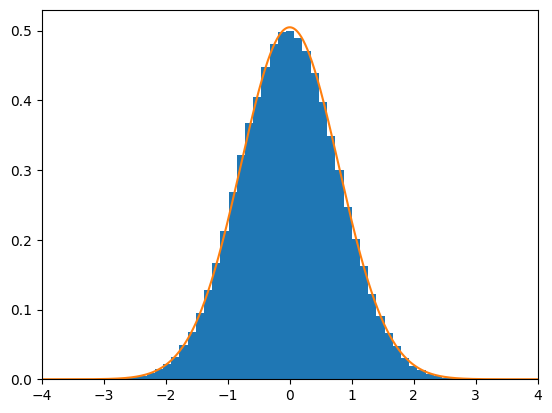

In [161]:
initial_positions = -0.5 + np.random.uniform()
samples = sampler.sample(initial_positions, num_samples=1_000_000, burn_in=25_000)

x = np.linspace(-10, 10, 10_000)
integral = integrate.quad(lambda x: trial.probability_function(x), -10., 10.)[0]
y = trial.probability_function_vmap(x)/integral
plt.hist(samples, density=True, bins=50)
plt.plot(x, y)
plt.xlim([-4., 4.])

In [163]:
psi = trial.evaluate_wf_vmap(samples)
laplacians = trial.laplacian_wf_vmap(samples)
variational_energy = hamiltonian.total_energy_vmap(psi, samples, laplacians)
energy, delta_energy = np.average(variational_energy), sem(variational_energy)
energies.append(energy)
delta_energies.append(delta_energy)
print('%5.3f \t %7.5f ± %f' % (alpha,energy,delta_energy))

0.537 	 0.51159 ± 0.000155


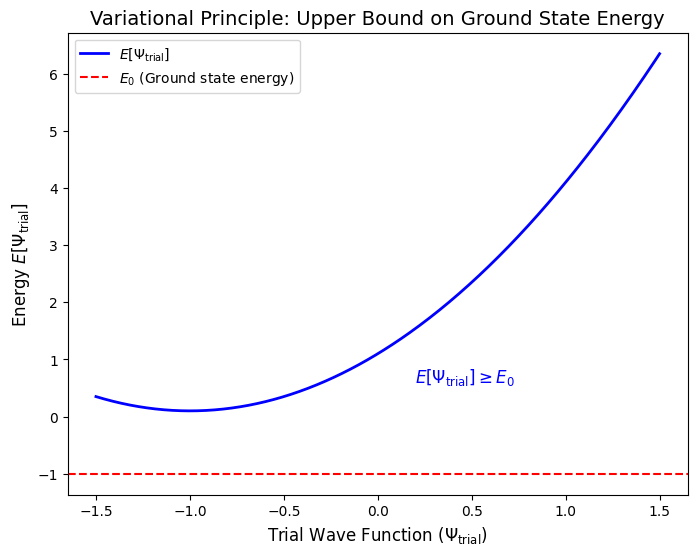

In [ ]:
# Correct the issue with LaTeX string rendering in matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Define the exact ground state energy (horizontal line) and the trial energy function
E0 = -1  # Ground state energy (exact)
variational_energies = np.linspace(-1.5, 1.5, 400)  # Range of trial energies
trial_wave_function_error = (variational_energies + 1)**2 + 0.1  # Example of energy as a function of error in trial wf

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(variational_energies, trial_wave_function_error, label=r"$E[\Psi_{\mathrm{trial}}]$", color='blue', lw=2)
plt.axhline(E0, color='red', linestyle='--', label=r"$E_0$ (Ground state energy)")

# Add labels and annotations
plt.xlabel(r'Trial Wave Function ($\Psi_{\mathrm{trial}}$)', fontsize=12)
plt.ylabel(r'Energy $E[\Psi_{\mathrm{trial}}]$', fontsize=12)
plt.title('Variational Principle: Upper Bound on Ground State Energy', fontsize=14)

# Highlight the variational principle statement
plt.text(0.2, 0.6, r"$E[\Psi_{\mathrm{trial}}] \geq E_0$", fontsize=12, color='blue')

# Add legend
plt.legend()

# Display the plot
plt.grid(False)
plt.savefig("variational_principle.svg", dpi=300)
plt.show()


In [218]:
gradientos

NameError: name 'gradientos' is not defined

In [179]:
x = np.linspace(-0.5, 0.5, 10_000)


In [178]:
trial = TrialWavefunction([jnp.array(0.5)])

In [179]:
trial.params

[Array(0.5, dtype=float32, weak_type=True)]

In [180]:
trial.evaluate_wf(0.5)

Array(0.8824969, dtype=float32, weak_type=True)

In [181]:
trial.laplacian_wf(0.5)

Array(-0.6618727, dtype=float32, weak_type=True)

In [163]:
initial_positions = 1.0
trial = TrialWavefunction(jnp.array(0.2))
samples = sampler.sample(initial_positions, num_samples=100_000, burn_in=25_000)
psi = trial.evaluate_wf_vmap(samples)
laplacians = trial.laplacian_wf_vmap(samples)
laplacian = trial.laplacian_wf(initial_positions)
hamiltonian.total_energy_vmap(psi, samples, laplacians)

Array([0.79117715, 0.8532381 , 0.73530054, ..., 0.34709567, 0.34778672,
       0.27983755], dtype=float32)

In [167]:
psi

Array([0.7546412 , 0.73266566, 0.7749901 , ..., 0.93235135, 0.93204457,
       0.9626957 ], dtype=float32)

In [170]:
samples

Array([ 1.1864083 ,  1.2471282 ,  1.1289487 , ..., -0.5918005 ,
       -0.593189  , -0.43599248], dtype=float32)

In [171]:
x = -0.43599248
alpha = 0.2
print(alpha + x**2 * (0.5 - 2 * alpha**2))

0.2798375658989512


In [ ]:
0.2 - 2 * 0.2**2

0.12

In [164]:
samples

Array([ 1.1864083 ,  1.2471282 ,  1.1289487 , ..., -0.5918005 ,
       -0.593189  , -0.43599248], dtype=float32)

In [148]:
samples = sampler.sample(initial_positions, 5_000)
psi = trial.evaluate_wf_vmap(samples)
laplacians = trial.laplacian_wf_vmap(samples)
hamiltonian.variational_energy(psi, samples, laplacians)

Array(0.50013375, dtype=float32)

In [149]:
sampler.trial_wavefunction.params

Array(-0.31766838, dtype=float32)

In [141]:
driver.run(100)

In [142]:
trial.params

Array(-10.399421, dtype=float32)

In [113]:
psi = trial.evaluate_wf_vmap(samples)
psi_laplacian = trial.laplacian_wf_vmap(samples)
grad_log_psi = trial.var_log_grads_vmap(trial.params, samples)
local_energies = hamiltonian.total_energy_vmap(psi, samples, psi_laplacian)
variational_energy = jnp.mean(local_energies)
jnp.mean(jnp.array([2*jnp.real((variational_energy - loc_en)*grad) for loc_en, grad in zip(local_energies, grad_log_psi)]), axis=0)

Array(-0.00670319, dtype=float32)

In [108]:
trial.params

Array(-226.3735, dtype=float32)

In [106]:
driver.energy_gradient(samples)

Array(2.1378677, dtype=float32)

In [88]:
a = [trial.params.tolist()]

In [82]:
b = [jnp.mean(driver.energy_gradient(samples), axis=0).tolist()]

In [84]:
for a, b in zip(a, b):
    print(a,b)

1.6547168493270874 -0.00902055948972702


In [74]:
zip(list(trial.params), list(jnp.mean(driver.energy_gradient(samples), axis=0)))

TypeError: iteration over a 0-d array

In [71]:
[p - j for p, j in zip(trial.params, jnp.mean(driver.energy_gradient(samples), axis=0))]

TypeError: iteration over a 0-d array

In [89]:
driver.energy_gradient(samples)

[Array(-0., dtype=float32),
 Array(-0., dtype=float32),
 Array(-0., dtype=float32),
 Array(-0., dtype=float32),
 Array(-0., dtype=float32),
 Array(-0., dtype=float32),
 Array(-0., dtype=float32),
 Array(-0., dtype=float32),
 Array(-0., dtype=float32),
 Array(-0., dtype=float32)]

In [107]:
driver.run(10)

In [70]:
hamiltonian = ManyBodyHamiltonian()
hamiltonian.total_energy_vmap(psi, samples, laplacians)

Array([0.98875684, 0.9835988 , 0.9992382 , 0.9512029 , 0.9917239 ,
       0.95104337, 0.82462066, 0.91650766, 0.8248569 , 0.8188392 ],      dtype=float32)

In [ ]:
# @partial(jax.jit, static_argnums=(1, 2))
# def compute_energy(samples, hamiltonian, trial_wavefunction, params):
#     def local_energy(positions):
#         # Pass the evaluate method of trial_wavefunction, not the object itself
#         kinetic = hamiltonian.kinetic_energy(positions, trial_wavefunction.evaluate, params)
#         potential = hamiltonian.potential_energy(positions)
#         return kinetic + potential

#     energies = jax.vmap(local_energy)(samples)
#     return jnp.mean(energies)

@partial(jax.jit, static_argnums = (0, 1))
@partial(jax.vmap, in_axes = (None, None, None, 0), out_axes = 0)
def local_energy(hamiltonian, trial_wavefunction, params, positions):
    kinetic = hamiltonian.kinetic_energy(positions, trial_wavefunction.evaluate, params)
    potential = hamiltonian.potential_energy(positions)
    return kinetic + potential

In [6]:
# Set up the system
mass = 1.0
omega = 1.0
hamiltonian = ManyBodyHamiltonian(mass, omega)

# Initialize trial wavefunction parameters (e.g., alpha = 1.0 for Gaussian)
initial_params = jnp.array([2.0])
trial_wavefunction = TrialWavefunction(initial_params)

# Initialize particle positions (for a single particle)
initial_positions = jnp.array([0.0])

# Initialize the Metropolis-Hastings sampler
step_size = 0.1
rng_key = jax.random.PRNGKey(42)
sampler = MetropolisHastingsSampler(trial_wavefunction, step_size, rng_key)

# Generate 10,000 samples with burn-in of 1,000 steps
num_samples = 10000
samples = sampler.sample(initial_positions, initial_params, num_samples, burn_in=1000)

# Compute the energy
mean_energy = jnp.mean(local_energy(hamiltonian, trial_wavefunction, initial_params, samples))
print("Estimated Ground State Energy:", mean_energy)


TypeError: Cannot interpret value of type <class 'method'> as an abstract array; it does not have a dtype attribute

In [31]:
samples

Array([[-1.910675 ],
       [-2.0129116],
       [-2.0724275],
       ...,
       [-0.9059723],
       [-0.9245706],
       [-0.9791429]], dtype=float32)

In [19]:
@jit
def energy_fn(params, positions):
    samples = sampler.sample(positions, params, num_samples=1000, burn_in=1000)
    return compute_energy(samples, hamiltonian, trial_wavefunction, params)

# Gradient of the energy with respect to the wavefunction parameters
energy_grad = grad(energy_fn)

# Gradient descent loop
learning_rate = 0.01
params = initial_params
positions = initial_positions

for i in range(100):  # Perform 100 gradient descent steps
    grads = energy_grad(params, positions)
    params -= learning_rate * grads
    print(f"Step {i}, params: {params}")

    mean_energy = jnp.mean(local_energy(hamiltonian, trial_wavefunction, params, samples))
    print("Estimated Ground State Energy:", mean_energy)


Step 0, params: [1.999309]
Estimated Ground State Energy: 0.92327857
Step 1, params: [1.9986179]
Estimated Ground State Energy: 0.9232342
Step 2, params: [1.9979268]
Estimated Ground State Energy: 0.92318994
Step 3, params: [1.9972358]
Estimated Ground State Energy: 0.9231454
Step 4, params: [1.9965446]
Estimated Ground State Energy: 0.9231011
Step 5, params: [1.9958534]
Estimated Ground State Energy: 0.9230566
Step 6, params: [1.9951622]
Estimated Ground State Energy: 0.92301226
Step 7, params: [1.9944711]
Estimated Ground State Energy: 0.922968
Step 8, params: [1.9937798]
Estimated Ground State Energy: 0.9229235
Step 9, params: [1.9930885]
Estimated Ground State Energy: 0.922879
Step 10, params: [1.9923974]
Estimated Ground State Energy: 0.92283463
Step 11, params: [1.9917091]
Estimated Ground State Energy: 0.9227903
Step 12, params: [1.9910309]
Estimated Ground State Energy: 0.92274666
Step 13, params: [1.9903526]
Estimated Ground State Energy: 0.922703
Step 14, params: [1.9896743]


In [42]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
import functools

class TrialWavefunction:
    def __init__(self, params):
        self.params = params

    # Function to evaluate the wavefunction
    def evaluate(self, positions, params):
        """Evaluate the Gaussian wavefunction: Ψ(x) = exp(-α * r²)."""
        alpha = params[0]  # Assuming params is a vector
        return jnp.exp(-alpha * jnp.sum(jnp.square(positions)))

    # Function to compute the gradient of the wavefunction
    def grad(self, positions, params):
        """Compute the gradient of the wavefunction with respect to positions."""
        alpha = params[0]
        return -2 * alpha * positions * self.evaluate(positions, params)


In [43]:
class ManyBodyHamiltonian:
    def __init__(self, mass, omega):
        self.mass = mass
        self.omega = omega

    def kinetic_energy(self, positions, evaluate_wavefunction, params):
        """Compute the kinetic energy using the gradient of the wavefunction."""
        grad_psi = grad(evaluate_wavefunction)(positions, params)
        return 0.5 * self.mass * jnp.sum(grad_psi ** 2)  # Example kinetic energy formula

    def potential_energy(self, positions):
        """Compute the potential energy using a harmonic oscillator."""
        return 0.5 * self.mass * self.omega ** 2 * jnp.sum(positions ** 2)


In [44]:
class MetropolisHastingsSampler:
    def __init__(self, trial_wavefunction, step_size, rng_key):
        self.trial_wavefunction = trial_wavefunction
        self.step_size = step_size
        self.rng_key = rng_key

    @functools.partial(jit, static_argnums=(0,))
    def propose_move(self, positions, key):
        """Propose a new move by adding Gaussian noise to the current positions."""
        move = random.normal(key, shape=positions.shape) * self.step_size
        new_positions = positions + move
        return new_positions

    @functools.partial(jit, static_argnums=(0,))
    def acceptance_prob(self, old_positions, new_positions, params):
        """Compute the Metropolis-Hastings acceptance probability."""
        # Use the evaluate method of trial_wavefunction, not the object itself
        psi_old = self.trial_wavefunction.evaluate(old_positions, params)
        psi_new = self.trial_wavefunction.evaluate(new_positions, params)
        return jnp.minimum(1.0, jnp.square(psi_new) / jnp.square(psi_old))

    @functools.partial(jit, static_argnums=(0,))
    def metropolis_step(self, positions, params, key):
        """Perform a single Metropolis-Hastings step."""
        new_key, subkey = random.split(key)
        new_positions = self.propose_move(positions, subkey)
        acc_prob = self.acceptance_prob(positions, new_positions, params)
        accept = random.uniform(subkey) < acc_prob
        positions = jnp.where(accept, new_positions, positions)
        return positions, new_key

    def sample(self, initial_positions, params, num_samples, burn_in=1000):
        """Generate samples using Metropolis-Hastings with fori_loop."""

        # Define a burn-in loop function
        def burn_in_step(i, state):
            positions, key = state
            positions, key = self.metropolis_step(positions, params, key)
            return positions, key

        # Define a sampling loop function
        def sample_step(i, state):
            positions, key, samples = state
            positions, key = self.metropolis_step(positions, params, key)
            samples = samples.at[i].set(positions)  # Store the positions
            return positions, key, samples

        # Burn-in phase
        positions, key = lax.fori_loop(0, burn_in, burn_in_step, (initial_positions, self.rng_key))

        # Initialize an array to store the samples
        samples = jnp.zeros((num_samples, initial_positions.shape[0]))

        # Sampling phase
        positions, key, samples = lax.fori_loop(
            0, num_samples, sample_step, (positions, key, samples)
        )

        return samples


In [ ]:
@functools.partial(jit, static_argnums=(1,))
def compute_energy(samples, hamiltonian, trial_wavefunction, params):
    def local_energy(positions):
        # Use the evaluate method of trial_wavefunction, not the object itself
        kinetic = hamiltonian.kinetic_energy(positions, trial_wavefunction.evaluate, params)
        potential = hamiltonian.potential_energy(positions)
        return kinetic + potential

    energies = vmap(local_energy)(samples)
    return jnp.mean(energies)


In [47]:
# Set up the system
mass = 1.0
omega = 1.0
hamiltonian = ManyBodyHamiltonian(mass, omega)

# Initialize trial wavefunction parameters (e.g., alpha = 1.0 for Gaussian)
initial_params = jnp.array([1.0])
trial_wavefunction = TrialWavefunction(initial_params)

# Initialize particle positions (for a single particle)
initial_positions = jnp.array([0.0])

# Initialize the Metropolis-Hastings sampler
step_size = 0.1
rng_key = random.PRNGKey(42)
sampler = MetropolisHastingsSampler(trial_wavefunction, step_size, rng_key)

# Generate 10,000 samples with burn-in of 1,000 steps
num_samples = 10000
samples = sampler.sample(initial_positions, initial_params, num_samples, burn_in=1000)

# Compute the energy
mean_energy = compute_energy(samples, hamiltonian, trial_wavefunction.evaluate, initial_params)
print("Estimated Ground State Energy:", mean_energy)


TypeError: Cannot interpret value of type <class 'method'> as an abstract array; it does not have a dtype attribute

In [48]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
import functools

class TrialWavefunction:
    def __init__(self, params):
        self.params = params

    def evaluate(self, positions, params):
        """Evaluate the Gaussian wavefunction: Ψ(x) = exp(-α * r²)."""
        alpha = params[0]  # Assuming params is a vector
        return jnp.exp(-alpha * jnp.sum(jnp.square(positions)))

    def grad(self, positions, params):
        """Compute the gradient of the wavefunction with respect to positions."""
        alpha = params[0]
        return -2 * alpha * positions * self.evaluate(positions, params)


In [49]:
class ManyBodyHamiltonian:
    def __init__(self, mass, omega):
        self.mass = mass
        self.omega = omega

    def kinetic_energy(self, positions, evaluate_wavefunction, params):
        """Compute the kinetic energy using the gradient of the wavefunction."""
        grad_psi = grad(evaluate_wavefunction)(positions, params)
        return 0.5 * self.mass * jnp.sum(grad_psi ** 2)

    def potential_energy(self, positions):
        """Compute the potential energy using a harmonic oscillator."""
        return 0.5 * self.mass * self.omega ** 2 * jnp.sum(positions ** 2)


In [50]:
class MetropolisHastingsSampler:
    def __init__(self, trial_wavefunction, step_size, rng_key):
        self.trial_wavefunction = trial_wavefunction
        self.step_size = step_size
        self.rng_key = rng_key

    @functools.partial(jit, static_argnums=(0,))
    def propose_move(self, positions, key):
        """Propose a new move by adding Gaussian noise to the current positions."""
        move = random.normal(key, shape=positions.shape) * self.step_size
        new_positions = positions + move
        return new_positions

    @functools.partial(jit, static_argnums=(0,))
    def acceptance_prob(self, old_positions, new_positions, params):
        """Compute the Metropolis-Hastings acceptance probability."""
        psi_old = self.trial_wavefunction.evaluate(old_positions, params)
        psi_new = self.trial_wavefunction.evaluate(new_positions, params)
        return jnp.minimum(1.0, jnp.square(psi_new) / jnp.square(psi_old))

    @functools.partial(jit, static_argnums=(0,))
    def metropolis_step(self, positions, params, key):
        """Perform a single Metropolis-Hastings step."""
        new_key, subkey = random.split(key)
        new_positions = self.propose_move(positions, subkey)
        acc_prob = self.acceptance_prob(positions, new_positions, params)
        accept = random.uniform(subkey) < acc_prob
        positions = jnp.where(accept, new_positions, positions)
        return positions, new_key

    def sample(self, initial_positions, params, num_samples, burn_in=1000):
        """Generate samples using Metropolis-Hastings with fori_loop."""

        # Define a burn-in loop function
        def burn_in_step(i, state):
            positions, key = state
            positions, key = self.metropolis_step(positions, params, key)
            return positions, key

        # Define a sampling loop function
        def sample_step(i, state):
            positions, key, samples = state
            positions, key = self.metropolis_step(positions, params, key)
            samples = samples.at[i].set(positions)  # Store the positions
            return positions, key, samples

        # Burn-in phase
        positions, key = lax.fori_loop(0, burn_in, burn_in_step, (initial_positions, self.rng_key))

        # Initialize an array to store the samples
        samples = jnp.zeros((num_samples, initial_positions.shape[0]))

        # Sampling phase
        positions, key, samples = lax.fori_loop(
            0, num_samples, sample_step, (positions, key, samples)
        )

        return samples


In [ ]:
def evaluate_wavefunction_fn(trial_wavefunction):
    """Helper function to return the evaluation function."""
    return lambda positions, params: trial_wavefunction.evaluate(positions, params)

@functools.partial(jit, static_argnums=(1,))
def compute_energy(samples, hamiltonian, evaluate_wavefunction_fn, params):
    """
    Compute the energy of the system using the provided wavefunction evaluation function.
    """
    def local_energy(positions):
        """Calculate the local energy (kinetic + potential) at each position."""
        # Compute the kinetic energy using the gradient of the wavefunction
        kinetic = hamiltonian.kinetic_energy(positions, evaluate_wavefunction_fn, params)

        # Compute the potential energy
        potential = hamiltonian.potential_energy(positions)

        return kinetic + potential

    # Use vmap to evaluate energy over all the samples
    energies = vmap(local_energy)(samples)

    # Return the mean energy
    return jnp.mean(energies)


In [56]:
# Set up the system
mass = 1.0
omega = 1.0
hamiltonian = ManyBodyHamiltonian(mass, omega)

# Initialize trial wavefunction parameters (e.g., alpha = 1.0 for Gaussian)
initial_params = jnp.array([1.0])
trial_wavefunction = TrialWavefunction(initial_params)

# Initialize particle positions (for a single particle)
initial_positions = jnp.array([0.0])

# Initialize the Metropolis-Hastings sampler
step_size = 0.1
rng_key = random.PRNGKey(42)
sampler = MetropolisHastingsSampler(trial_wavefunction, step_size, rng_key)

# Generate 10,000 samples with burn-in of 1,000 steps
num_samples = 10000
samples = sampler.sample(initial_positions, initial_params, num_samples, burn_in=1000)

# Create a function to access the evaluate method
evaluate_fn = evaluate_wavefunction_fn(trial_wavefunction)

# Compute the energy
mean_energy = compute_energy(samples, hamiltonian, evaluate_fn, initial_params)
print("Estimated Ground State Energy:", mean_energy)


TypeError: Cannot interpret value of type <class 'function'> as an abstract array; it does not have a dtype attribute

In [57]:
evaluate_fn

<function __main__.evaluate_wavefunction_fn.<locals>.<lambda>(positions, params)>

In [58]:
import jax
import jax.numpy as jnp
from jax import random, vmap, jit
import functools

# Define the TrialWavefunction class
class TrialWavefunction:
    def __init__(self, params):
        self.params = params

    def evaluate(self, positions, params):
        """Evaluate the trial wavefunction at given positions with parameters."""
        alpha = params[0]
        return jnp.exp(-alpha * jnp.sum(positions ** 2))  # Example wavefunction

# Hamiltonian class (simplified for this example)
class ManyBodyHamiltonian:
    def __init__(self, mass, omega):
        self.mass = mass
        self.omega = omega

    def kinetic_energy(self, positions, evaluate_fn, params):
        """Compute the kinetic energy."""
        grad_wavefunction = jax.grad(lambda x: evaluate_fn(x, params))(positions)
        return -0.5 * jnp.sum(grad_wavefunction ** 2) / self.mass

    def potential_energy(self, positions):
        """Compute the potential energy."""
        return 0.5 * self.omega ** 2 * jnp.sum(positions ** 2)

# Refactor to make compute_energy compatible with JAX
@functools.partial(jit, static_argnums=(1,))
def compute_energy(samples, hamiltonian, evaluate_fn, params):
    def local_energy(positions):
        kinetic = hamiltonian.kinetic_energy(positions, evaluate_fn, params)
        potential = hamiltonian.potential_energy(positions)
        return kinetic + potential

    # Use vmap to vectorize energy computation over all samples
    energies = vmap(local_energy)(samples)
    return jnp.mean(energies)

# JAX sampler using Metropolis-Hastings
class MetropolisHastingsSampler:
    def __init__(self, trial_wavefunction, step_size, rng_key):
        self.trial_wavefunction = trial_wavefunction
        self.step_size = step_size
        self.rng_key = rng_key

    def sample(self, initial_positions, initial_params, num_samples, burn_in=0):
        positions = initial_positions
        params = initial_params
        samples = []
        for _ in range(num_samples + burn_in):
            new_positions = positions + self.step_size * random.normal(self.rng_key, positions.shape)
            acceptance_ratio = self.trial_wavefunction.evaluate(new_positions, params) / self.trial_wavefunction.evaluate(positions, params)
            if random.uniform(self.rng_key) < acceptance_ratio:
                positions = new_positions
            if _ >= burn_in:
                samples.append(positions)
        return jnp.array(samples)

# Helper function to wrap the `evaluate` method as a pure function
def evaluate_wavefunction_fn(trial_wavefunction):
    return lambda positions, params: trial_wavefunction.evaluate(positions, params)

# Example usage:
mass = 1.0
omega = 1.0
hamiltonian = ManyBodyHamiltonian(mass, omega)

# Initialize trial wavefunction parameters (e.g., alpha = 1.0 for Gaussian)
initial_params = jnp.array([1.0])
trial_wavefunction = TrialWavefunction(initial_params)

# Initialize particle positions (for a single particle)
initial_positions = jnp.array([0.0])

# Initialize the Metropolis-Hastings sampler
step_size = 0.1
rng_key = random.PRNGKey(42)
sampler = MetropolisHastingsSampler(trial_wavefunction, step_size, rng_key)

# Generate 10,000 samples with burn-in of 1,000 steps
num_samples = 10000
samples = sampler.sample(initial_positions, initial_params, num_samples, burn_in=1000)

# Create a function to access the evaluate method as a pure function
evaluate_fn = evaluate_wavefunction_fn(trial_wavefunction)

# Compute the energy
mean_energy = compute_energy(samples, hamiltonian, evaluate_fn, initial_params)
print("Estimated Ground State Energy:", mean_energy)


TypeError: Cannot interpret value of type <class 'function'> as an abstract array; it does not have a dtype attribute

In [59]:
samples

Array([[-9.327932],
       [-9.327932],
       [-9.327932],
       ...,
       [-9.327932],
       [-9.327932],
       [-9.327932]], dtype=float32)

In [1]:
import jax.numpy as jnp
import jax
from jax import random, jit, vmap, grad
import functools

class TrialWavefunction:
    def __init__(self, params):
        self.params = params

    def evaluate(self, positions, params):
        """Gaussian trial wavefunction evaluation."""
        alpha = params[0]
        return jnp.exp(-alpha * jnp.sum(positions**2))


In [2]:
class ManyBodyHamiltonian:
    def __init__(self, mass, omega):
        self.mass = mass
        self.omega = omega

    def potential_energy(self, positions):
        """Harmonic oscillator potential: V(x) = 1/2 * m * omega^2 * x^2"""
        return 0.5 * self.mass * self.omega**2 * jnp.sum(positions**2)

    def kinetic_energy(self, positions, evaluate_wavefunction_fn, params):
        """Kinetic energy: -1/2m * Laplacian of the wavefunction."""
        def log_psi(positions):
            return jnp.log(evaluate_wavefunction_fn(positions, params))

        grad_log_psi = grad(log_psi)
        grad2_log_psi = grad(lambda pos: jnp.sum(grad_log_psi(pos)**2))

        return -0.5 / self.mass * grad2_log_psi(positions)


In [3]:
class MetropolisHastingsSampler:
    def __init__(self, wavefunction, step_size, rng_key):
        self.wavefunction = wavefunction
        self.step_size = step_size
        self.rng_key = rng_key

    def sample(self, initial_positions, params, num_samples, burn_in=1000):
        def metropolis_step(carry, _):
            key, positions, accepted = carry
            key, subkey = random.split(key)
            proposed_move = positions + random.normal(subkey, shape=positions.shape) * self.step_size

            psi_old = self.wavefunction.evaluate(positions, params)
            psi_new = self.wavefunction.evaluate(proposed_move, params)
            acceptance_ratio = (psi_new / psi_old)**2

            key, subkey = random.split(key)
            accept = random.uniform(subkey) < acceptance_ratio
            new_positions = jnp.where(accept, proposed_move, positions)
            return (key, new_positions, accepted + accept), new_positions

        # Run Metropolis-Hastings for burn-in
        carry = (self.rng_key, initial_positions, 0)
        carry, _ = jax.lax.fori_loop(0, burn_in, metropolis_step, carry)

        # Generate samples after burn-in
        carry, samples = jax.lax.scan(metropolis_step, carry, None, length=num_samples)
        return samples


In [ ]:
@functools.partial(jit, static_argnums=(2,))
def compute_energy(samples, hamiltonian, evaluate_wavefunction_fn, params):
    """
    Compute the energy of the system using the provided wavefunction evaluation function.
    """
    def local_energy(positions):
        """Calculate the local energy (kinetic + potential) at each position."""
        # Compute the kinetic energy using the gradient of the wavefunction
        kinetic = hamiltonian.kinetic_energy(positions, evaluate_wavefunction_fn, params)

        # Compute the potential energy
        potential = hamiltonian.potential_energy(positions)

        return kinetic + potential

    # Use vmap to evaluate energy over all the samples
    energies = vmap(local_energy)(samples)

    # Return the mean energy
    return jnp.mean(energies)


In [5]:
# Define helper function for wavefunction evaluation
def evaluate_wavefunction_fn(trial_wavefunction):
    """Helper function to return the evaluation function."""
    return lambda positions, params: trial_wavefunction.evaluate(positions, params)

# Set up the system
mass = 1.0
omega = 1.0
hamiltonian = ManyBodyHamiltonian(mass, omega)

# Initialize trial wavefunction parameters (e.g., alpha = 1.0 for Gaussian)
initial_params = jnp.array([1.0])
trial_wavefunction = TrialWavefunction(initial_params)

# Initialize particle positions (for a single particle)
initial_positions = jnp.array([0.0])

# Initialize the Metropolis-Hastings sampler
step_size = 0.1
rng_key = random.PRNGKey(42)
sampler = MetropolisHastingsSampler(trial_wavefunction, step_size, rng_key)

# Generate 10,000 samples with burn-in of 1,000 steps
num_samples = 10000
samples = sampler.sample(initial_positions, initial_params, num_samples, burn_in=1000)

# Create a function to access the evaluate method
evaluate_fn = evaluate_wavefunction_fn(trial_wavefunction)

# Compute the energy using the static argument for the wavefunction evaluation
mean_energy = compute_energy(samples, hamiltonian, evaluate_fn, initial_params)
print("Estimated Ground State Energy:", mean_energy)


TypeError: iteration over a 0-d array

In [ ]:
import jax.numpy as jnp
import jax
from jax import random, jit, vmap, grad
import functools

# Trial wavefunction class
class TrialWavefunction:
    def __init__(self, params):
        self.params = params

    def evaluate(self, positions, params):
        """Gaussian trial wavefunction evaluation."""
        alpha = params[0]
        return jnp.exp(-alpha * jnp.sum(positions**2))

# Hamiltonian class
class ManyBodyHamiltonian:
    def __init__(self, mass, omega):
        self.mass = mass
        self.omega = omega

    def potential_energy(self, positions):
        """Harmonic oscillator potential: V(x) = 1/2 * m * omega^2 * x^2"""
        return 0.5 * self.mass * self.omega**2 * jnp.sum(positions**2)

    def kinetic_energy(self, positions, evaluate_wavefunction_fn, params):
        """Kinetic energy: -1/2m * Laplacian of the wavefunction."""
        def log_psi(positions):
            return jnp.log(evaluate_wavefunction_fn(positions, params))

        grad_log_psi = grad(log_psi)
        grad2_log_psi = grad(lambda pos: jnp.sum(grad_log_psi(pos)**2))

        return -0.5 / self.mass * grad2_log_psi(positions)

# Metropolis-Hastings sampler class
class MetropolisHastingsSampler:
    def __init__(self, wavefunction, step_size, rng_key):
        self.wavefunction = wavefunction
        self.step_size = step_size
        self.rng_key = rng_key

    def sample(self, initial_positions, params, num_samples, burn_in=1000):
        def metropolis_step(carry, _):
            key, positions, accepted = carry
            key, subkey = random.split(key)
            proposed_move = positions + random.normal(subkey, shape=positions.shape) * self.step_size

            psi_old = self.wavefunction.evaluate(positions, params)
            psi_new = self.wavefunction.evaluate(proposed_move, params)
            acceptance_ratio = (psi_new / psi_old)**2

            key, subkey = random.split(key)
            accept = random.uniform(subkey) < acceptance_ratio
            new_positions = jnp.where(accept, proposed_move, positions)
            return (key, new_positions, accepted + accept), new_positions

        # Ensure that initial_positions is at least 1D
        initial_positions = jnp.atleast_1d(initial_positions)

        # Run Metropolis-Hastings for burn-in
        carry = (self.rng_key, initial_positions, 0)
        carry, _ = jax.lax.fori_loop(0, burn_in, metropolis_step, carry)

        # Generate samples after burn-in
        carry, samples = jax.lax.scan(metropolis_step, carry, None, length=num_samples)
        return samples

# Energy computation function
@functools.partial(jit, static_argnums=(2,))
def compute_energy(samples, hamiltonian, evaluate_wavefunction_fn, params):
    """
    Compute the energy of the system using the provided wavefunction evaluation function.
    """
    def local_energy(positions):
        """Calculate the local energy (kinetic + potential) at each position."""
        kinetic = hamiltonian.kinetic_energy(positions, evaluate_wavefunction_fn, params)
        potential = hamiltonian.potential_energy(positions)
        return kinetic + potential

    # Use vmap to evaluate energy over all the samples
    energies = vmap(local_energy)(samples)

    return jnp.mean(energies)

# Define helper function for wavefunction evaluation
def evaluate_wavefunction_fn(trial_wavefunction):
    return lambda positions, params: trial_wavefunction.evaluate(positions, params)

# Set up the system
mass = 1.0
omega = 1.0
hamiltonian = ManyBodyHamiltonian(mass, omega)

# Initialize trial wavefunction parameters
initial_params = jnp.array([1.0])
trial_wavefunction = TrialWavefunction(initial_params)

# Initialize particle positions (ensure 1D array)
initial_positions = jnp.array([0.0])

# Initialize the Metropolis-Hastings sampler
step_size = 0.1
rng_key = random.PRNGKey(42)
sampler = MetropolisHastingsSampler(trial_wavefunction, step_size, rng_key)

# Generate 10,000 samples with burn-in of 1,000 steps
num_samples = 10000
samples = sampler.sample(initial_positions, initial_params, num_samples, burn_in=1000)

# Create a function to access the evaluate method
evaluate_fn = evaluate_wavefunction_fn(trial_wavefunction)

# Compute the energy using the static argument for the wavefunction evaluation
mean_energy = compute_energy(samples, hamiltonian, evaluate_fn, initial_params)
print("Estimated Ground State Energy:", mean_energy)


TypeError: iteration over a 0-d array